In [2]:
import os
import glob
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import pickle

In [3]:
# =========================================================
# 1. LOAD DATASET
# =========================================================
def load_palm_vein_dataset(
    data_root="../Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=20
):
    X = []
    y = []
    label_names = []

    all_dirs = sorted(
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d))
    )
    person_dirs = all_dirs[:num_persons]
    print(f"Using these persons: {person_dirs}")

    for label_idx, person in enumerate(person_dirs):
        label_names.append(person)
        folder = os.path.join(data_root, person)

        img_paths = []
        for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            img_paths.extend(glob.glob(os.path.join(folder, ext)))

        if not img_paths:
            print(f"Warning: no images found in {folder}")
            continue

        for path in img_paths:
            img = Image.open(path).convert("L").resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0
            X.append(arr.flatten())
            y.append(label_idx)

    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y, label_names


# =========================================================
# 2. LOAD + 3-WAY SPLIT (train / verification / test)
# =========================================================
X, y, label_names = load_palm_vein_dataset(
    data_root="../Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30
)
print("X shape:", X.shape, "y shape:", y.shape, "#classes:", len(label_names))

# First split off test (20%)
X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Then split trainval into train (e.g. 70%) and verification (e.g. 10%)
# If you want 70/10/20 overall, verification fraction of trainval is 0.10 / 0.80 = 0.125
X_train_raw, X_ver_raw, y_train, y_ver = train_test_split(
    X_trainval_raw, y_trainval, test_size=0.125, stratify=y_trainval, random_state=42
)

print("Train:", X_train_raw.shape[0], "Ver:", X_ver_raw.shape[0], "Test:", X_test_raw.shape[0])


# =========================================================
# 3. Standardization + PCA (fit on TRAIN only!)
# =========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_ver_scaled   = scaler.transform(X_ver_raw)
X_test_scaled  = scaler.transform(X_test_raw)

n_components = 150
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_ver_pca   = pca.transform(X_ver_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("X_train_pca:", X_train_pca.shape, "X_ver_pca:", X_ver_pca.shape, "X_test_pca:", X_test_pca.shape)



Using these persons: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030']
X shape: (360, 65536) y shape: (360,) #classes: 30
Train: 252 Ver: 36 Test: 72
X_train_pca: (252, 150) X_ver_pca: (36, 150) X_test_pca: (72, 150)


In [4]:
# =========================================================
# 4. Train SVM (IDENTIFICATION model)
# =========================================================
svm = SVC(probability=True, random_state=42)

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.0001, 0.001, 0.1],
    "kernel": ["rbf", "poly"]
}

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring="accuracy"
)
grid.fit(X_train_pca, y_train)

best_svm = grid.best_estimator_
print("Best params:", grid.best_params_, "Best CV acc:", grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} Best CV acc: 0.7738095238095237



[TRAIN] Identification accuracy: 1.0000
              precision    recall  f1-score   support

        0001       1.00      1.00      1.00         9
        0002       1.00      1.00      1.00         8
        0003       1.00      1.00      1.00         8
        0004       1.00      1.00      1.00         8
        0005       1.00      1.00      1.00         9
        0006       1.00      1.00      1.00         8
        0007       1.00      1.00      1.00         8
        0008       1.00      1.00      1.00         8
        0009       1.00      1.00      1.00         8
        0010       1.00      1.00      1.00         9
        0011       1.00      1.00      1.00         8
        0012       1.00      1.00      1.00         8
        0013       1.00      1.00      1.00         9
        0014       1.00      1.00      1.00         9
        0015       1.00      1.00      1.00         8
        0016       1.00      1.00      1.00         9
        0017       1.00      1.00      1

c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\kxy\miniconda3\envs\py10\lib\site-packages\sklearn\metrics\_clas

<Figure size 700x700 with 0 Axes>

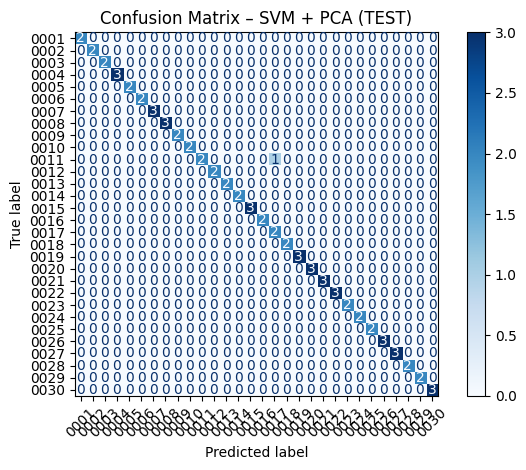

In [5]:
# =========================================================
# 5. Identification evaluation (train/ver/test)
# =========================================================
def eval_identification(model, Xpca, ytrue, label_names, split_name=""):
    ypred = model.predict(Xpca)
    acc = accuracy_score(ytrue, ypred)
    print(f"\n[{split_name}] Identification accuracy: {acc:.4f}")
    print(classification_report(ytrue, ypred, target_names=label_names))
    cm = confusion_matrix(ytrue, ypred)
    return acc, cm

train_acc, _ = eval_identification(best_svm, X_train_pca, y_train, label_names, "TRAIN")
ver_acc,   _ = eval_identification(best_svm, X_ver_pca,   y_ver,   label_names, "VER")
test_acc,  cm_test = eval_identification(best_svm, X_test_pca,  y_test,  label_names, "TEST")

plt.figure(figsize=(7,7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix – SVM + PCA (TEST)")
plt.tight_layout()
plt.show()


Best similarity threshold on VER set: 0.200  (trial-acc=1.0000)


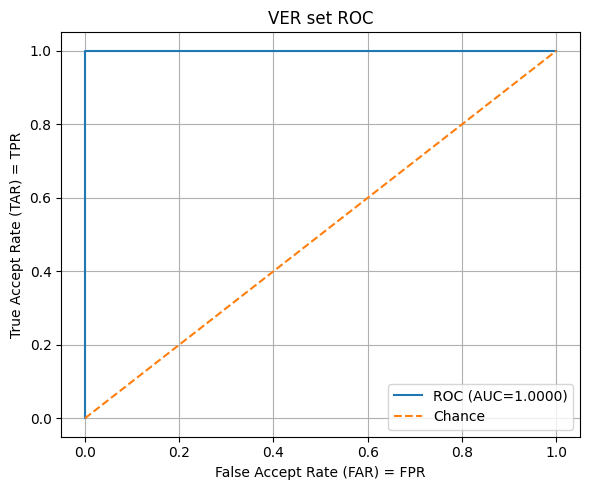

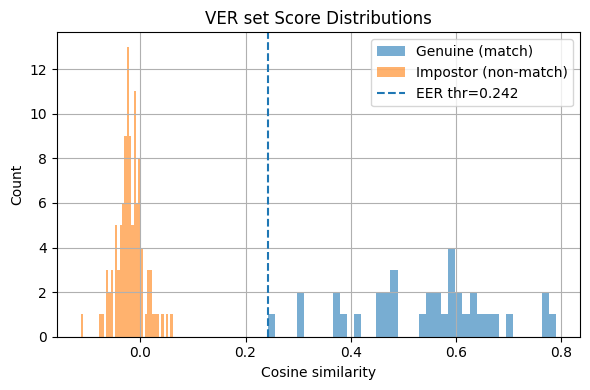

VER: AUC=1.0000, EER=0.0000, EER_thr=0.2420


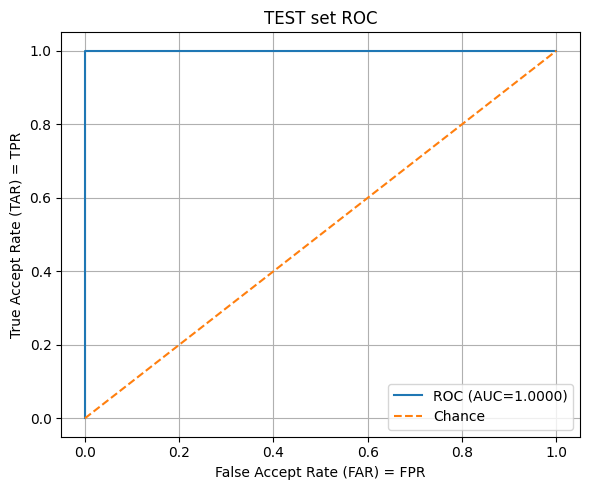

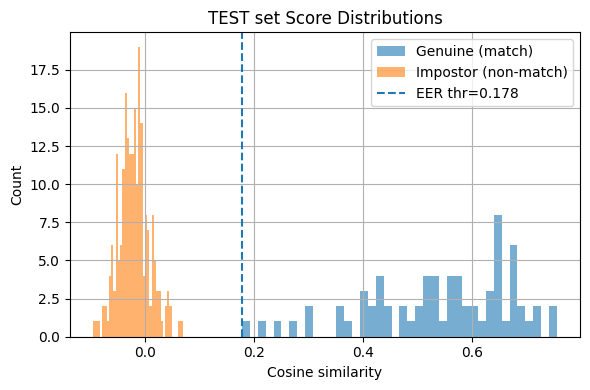

TEST: AUC=1.0000, EER=0.0000, EER_thr=0.1777


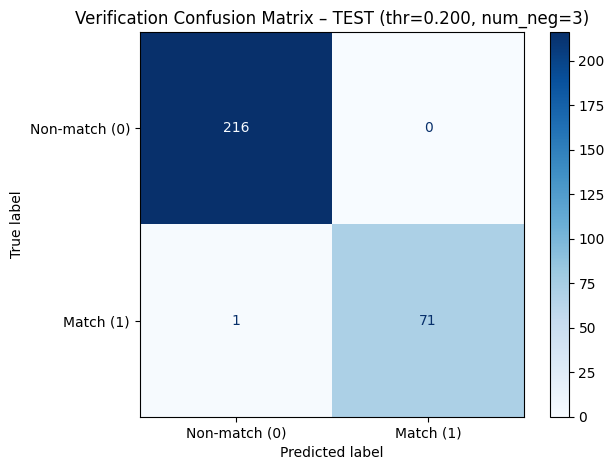

In [6]:
# =========================================================
# 6. Similarity-based VERIFICATION (PCA template matching)
#    + L2 NORMALIZATION
# =========================================================
from sklearn.metrics import roc_curve, roc_auc_score

def l2_normalize(x, axis=1, eps=1e-12):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 1:
        n = np.linalg.norm(x) + eps
        return x / n
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (n + eps)

def cosine_similarity(a, b, eps=1e-8):
    # assumes a and b are already normalized; keep eps for safety
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    return float(np.dot(a, b) / ((np.linalg.norm(a)+eps) * (np.linalg.norm(b)+eps)))

def build_class_templates(X_train_pca, y_train, num_classes, normalize=True):
    """
    Template per class = mean PCA vector of training samples for that class.
    Then L2-normalize templates for stable cosine.
    """
    templates = np.zeros((num_classes, X_train_pca.shape[1]), dtype=np.float32)
    for c in range(num_classes):
        idx = np.where(y_train == c)[0]
        if len(idx) == 0:
            raise ValueError(f"No training samples for class {c}")
        templates[c] = X_train_pca[idx].mean(axis=0)

    if normalize:
        templates = l2_normalize(templates, axis=1)
    return templates

num_classes = len(label_names)
templates = build_class_templates(X_train_pca, y_train, num_classes=num_classes, normalize=True)

# Normalize PCA features too (IMPORTANT if you use cosine)
X_train_pca_n = l2_normalize(X_train_pca, axis=1)
X_ver_pca_n   = l2_normalize(X_ver_pca, axis=1)
X_test_pca_n  = l2_normalize(X_test_pca, axis=1)


# =========================================================
# 7. Tune verification threshold on VERIFICATION set
#    (same impostor sampling) + keep sims for ROC
# =========================================================
def build_trials(
    X_pca_norm, y, templates,
    num_neg_per_sample=3,
    rng_seed=42
):
    """
    Build verification trials:
      - Positive: (sample, claimed = true class) -> label 1
      - Negative: (sample, claimed = random other class) -> label 0
    Returns:
      sims: cosine similarities
      gt  : 1 genuine, 0 impostor
    """
    rng = np.random.default_rng(rng_seed)
    C = templates.shape[0]

    sims, gt = [], []

    for i in range(len(y)):
        true_c = int(y[i])
        x = X_pca_norm[i]

        # positive
        sims.append(float(np.dot(x, templates[true_c])))  # both normalized -> cosine = dot
        gt.append(1)

        # negatives
        for _ in range(num_neg_per_sample):
            neg_c = int(rng.integers(0, C))
            while neg_c == true_c:
                neg_c = int(rng.integers(0, C))
            sims.append(float(np.dot(x, templates[neg_c])))
            gt.append(0)

    return np.array(sims, dtype=np.float32), np.array(gt, dtype=np.int64)

def tune_threshold_from_trials(sims, gt, thresholds=np.linspace(0.2, 0.99, 200)):
    best_t, best_acc = None, -1.0
    for t in thresholds:
        pred = (sims >= t).astype(int)
        acc = float(np.mean(pred == gt))
        if acc > best_acc:
            best_acc = acc
            best_t = float(t)
    return best_t, best_acc

# Build VER trials (same logic, num_neg_per_sample=3)
ver_sims, ver_gt = build_trials(
    X_ver_pca_n, y_ver, templates,
    num_neg_per_sample=3,
    rng_seed=42
)

best_thr, ver_trial_acc = tune_threshold_from_trials(ver_sims, ver_gt)
print(f"\nBest similarity threshold on VER set: {best_thr:.3f}  (trial-acc={ver_trial_acc:.4f})")


# =========================================================
# 8. ROC / AUC / EER + score distribution plots (VER and TEST)
# =========================================================
def compute_eer(fpr, tpr, thresholds):
    fnr = 1.0 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = float((fpr[idx] + fnr[idx]) / 2.0)
    eer_thr = float(thresholds[idx])
    return eer, eer_thr

def plot_roc_and_scores(sims, gt, title_prefix=""):
    fpr, tpr, thr = roc_curve(gt, sims)
    auc = float(roc_auc_score(gt, sims))
    eer, eer_thr = compute_eer(fpr, tpr, thr)

    # ROC
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
    plt.plot([0,1], [0,1], "--", label="Chance")
    plt.xlabel("False Accept Rate (FAR) = FPR")
    plt.ylabel("True Accept Rate (TAR) = TPR")
    plt.title(f"{title_prefix} ROC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Score distributions
    sims_g = sims[gt == 1]
    sims_i = sims[gt == 0]

    plt.figure(figsize=(6,4))
    plt.hist(sims_g, bins=40, alpha=0.6, label="Genuine (match)")
    plt.hist(sims_i, bins=40, alpha=0.6, label="Impostor (non-match)")
    plt.axvline(eer_thr, linestyle="--", label=f"EER thr={eer_thr:.3f}")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} Score Distributions")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return auc, eer, eer_thr

# VER plots
ver_auc, ver_eer, ver_eer_thr = plot_roc_and_scores(ver_sims, ver_gt, title_prefix="VER set")
print(f"VER: AUC={ver_auc:.4f}, EER={ver_eer:.4f}, EER_thr={ver_eer_thr:.4f}")

# TEST trials + plots (same impostor sampling)
test_sims, test_gt = build_trials(
    X_test_pca_n, y_test, templates,
    num_neg_per_sample=3,
    rng_seed=123
)
test_auc, test_eer, test_eer_thr = plot_roc_and_scores(test_sims, test_gt, title_prefix="TEST set")
print(f"TEST: AUC={test_auc:.4f}, EER={test_eer:.4f}, EER_thr={test_eer_thr:.4f}")

# Confusion matrix at threshold tuned on VER (best_thr)
test_pred = (test_sims >= best_thr).astype(int)
cm = confusion_matrix(test_gt, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-match (0)", "Match (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Verification Confusion Matrix – TEST (thr={best_thr:.3f}, num_neg=3)")
plt.tight_layout()
plt.show()



In [9]:
# =========================================================
# 9. Single-image verification (normalized PCA feature + normalized template)
# =========================================================
def verify_image_similarity_pca(
    scaler, pca, templates, img_path, claimed_person_name, label_names,
    img_size=(256,256),
    threshold=0.6
):
    if claimed_person_name not in label_names:
        raise ValueError(f"claimed_person_name '{claimed_person_name}' not in label_names")
    claimed_id = label_names.index(claimed_person_name)

    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0
    x_raw = arr.flatten().reshape(1, -1)

    x_scaled = scaler.transform(x_raw)
    x_pca = pca.transform(x_scaled)[0]          # (D,)
    x_pca = l2_normalize(x_pca)                 # normalize probe

    sim = float(np.dot(x_pca, templates[claimed_id]))  # cosine = dot
    is_match = sim >= threshold
    return is_match, claimed_person_name, sim

# example usage
test_img_path = "../Multispectral Palmprint Database/NIR/0001/2_05.jpg"
is_match, claimed_name, sim = verify_image_similarity_pca(
    scaler=scaler,
    pca=pca,
    templates=templates,
    img_path=test_img_path,
    claimed_person_name="0001",
    label_names=label_names,
    img_size=(256,256),
    threshold=best_thr
)

print("\nVerification (similarity-based)")
print("Claimed:", claimed_name)
print("Similarity:", sim)
print("Match:", is_match)


Verification (similarity-based)
Claimed: 0001
Similarity: 0.4597269892692566
Match: True


In [10]:
# =========================================================
# 10. Save everything
# =========================================================
model_path = "palm_svm_pca_with_ver_split_and_similarity.sav"
with open(model_path, "wb") as f:
    pickle.dump(
        {
            "svm": best_svm,
            "scaler": scaler,
            "pca": pca,
            "label_names": label_names,
            "templates": templates,
            "best_similarity_threshold": best_thr
        },
        f
    )
print(f"\nSaved model bundle to: {model_path}")


Saved model bundle to: palm_svm_pca_with_ver_split_and_similarity.sav
